# Kaggle 연동

[자전거 수요 예측 캐글 링크](https://www.kaggle.com/c/bike-sharing-demand/data)

In [1]:
# 캐글 API 버전 갱신을 위한 작업... 반드시 버전이 1.5.6 이어야 함

!ls -lha kaggle.json

!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6


# 캐글연동을 위한 토큰 입력
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


# 버전이 1.5.6 이 아니면, 진행할 수 없다
! kaggle -v

-rw-r--r-- 1 root root 66 Nov 16 06:50 kaggle.json
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=bd3745954395a32a7aed1af6f3ee29e409fa3681240eda1675343e5e5cd2b1ac
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
Kaggle API 1.5.6


In [2]:
! kaggle competitions download -c bike-sharing-demand

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 66.7MB/s]


In [0]:
import zipfile
import os

os.mkdir('/content/input')

zip_ref = zipfile.ZipFile("/content/bike-sharing-demand.zip", 'r')
zip_ref.extractall("/content/input")
zip_ref.close()

#시각화 필요 라이브러리

In [0]:
import pandas as pd
import calendar
from datetime import datetime
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import warnings
#to graph in notebook.
%matplotlib inline

#more than view digit range
plt.style.use('ggplot')

#anti broken minus font
mpl.rcParams['axes.unicode_minus'] = False


pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)


# 데이터 정제 및 설계 (EDA)

- 컬럼과 널 값을 훑어본다.

In [5]:
#컬럼의 수는 12의 데이터수는 10886
data = pd.read_csv("/content/input/train.csv")
data.shape


(10886, 12)

In [6]:
data.head(20)
#풍향에 대한 0 이 많음 널 값이 아닌 데이터값을 0으로 둔 것이 아닐까라는 예측을 하고 missing data인지 시각화를 통해 본다.

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


# 널값 찾기(missingno as msno)

In [7]:
data.isnull().sum()
# null 값이 없으므로 연관성이 있음을 알 수 있고, Feature engineering 을 생각해야한다.

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

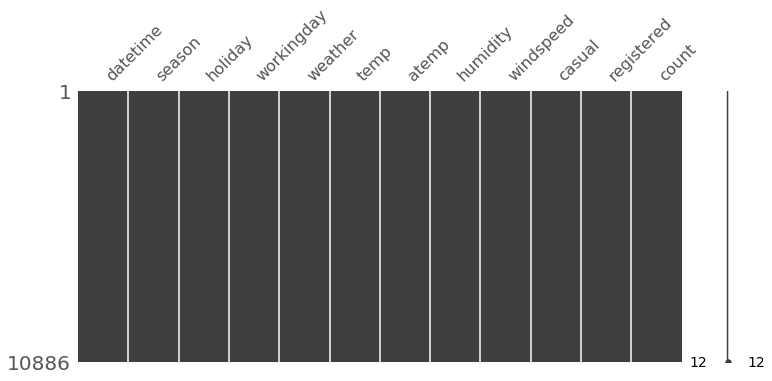

In [8]:
#널값의 시각화
msno.matrix(data,figsize=(12,5))

In [9]:
#다음과 같은 컬럼과 데이터 타입을 볼 수 있다.
data.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

# 데이터 질적 자료, 양적 자료 분류(주관적인 판단)

- 질적 자료
:season, holiday, workingday weather, datetime,

- 양적 자료
:temp, atemp, humidity, windspeed, casual, registered, count  
  

- season = 1. 봄 2. 여름 3. 가을 4. 겨울
- holiday = not working
- weather 1: 맑음 2:습함, 흐림 3: 적은 비, 눈 4: 많은 비, 눈 
  데이터를 보아 가정한다.

# 자료를 의미있는 데이터로 변경 (Transform)  

- datetime >> month, day, hour. minute, second


In [0]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [11]:
data.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
date           object
hour            int64
year           object
weekday         int64
month           int64
dtype: object

In [0]:
#양적을 질적 자료로 변경
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
  data[var] = data[var].astype("category")

In [0]:
#datetime은 이제 필요없으니 드랍!!
data = data.drop(["datetime"], axis=1)

In [14]:
data.head() # 뒤쪽의 date 부터 생성됨을 확인.

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,0,2011,5,1
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,1,2011,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2,2011,5,1
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,3,2011,5,1
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,4,2011,5,1



# 대여량에 대한 변수들의 관계 시각화

[Text(0.5, 1.0, 'per time')]

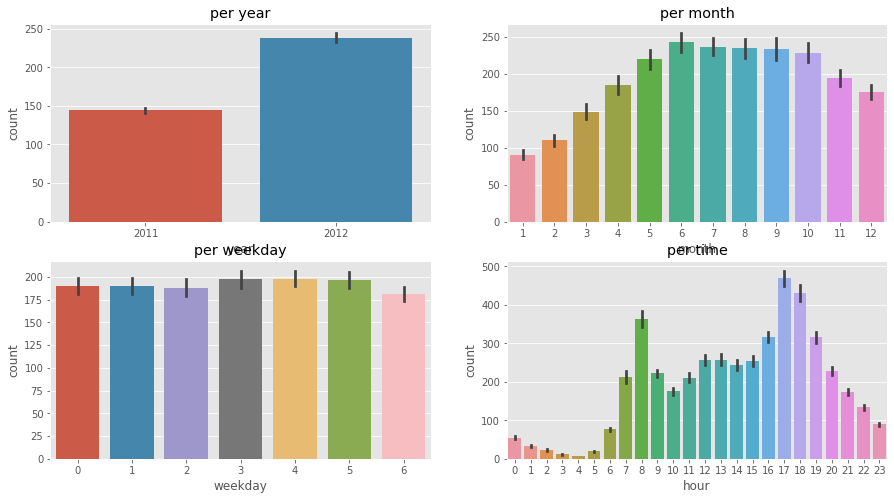

In [15]:
figure, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(15,8)

sns.barplot(data=data, x="year",y="count",ax=ax1)
sns.barplot(data=data, x="month", y ="count", ax=ax2)
sns.barplot(data=data, x="weekday", y="count", ax=ax3)
sns.barplot(data=data, x="hour", y="count", ax=ax4)

ax1.set(ylabel = 'count', title = "per year")
ax2.set(title="per month")
ax3.set(title="per weekday")
ax4.set(title="per time")

sns.barplot(data= , x="", y"" , ax= ) 을 통한 시각화  
- 2012 년에 더 많은 이용자
- 여름,가을에 더 많은 이용자
- 수목금 차이가 없지만 조금더 많은 이용객
- 출퇴근 시간에 더 많은 이용객.
  
fig, axes = plt.subplots(2, 2)
sns.boxplot(data= , y="" , x="", ax= axes[][] )
axes[][].set(xlabel="",ylabel="")


[Text(0, 0.5, 'count'),
 Text(0.5, 0, 'working day'),
 Text(0.5, 1.0, 'per working day')]

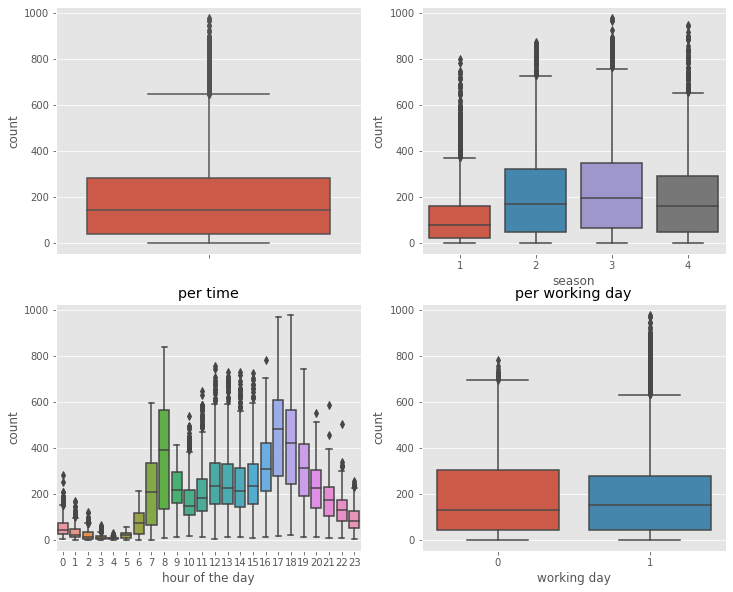

In [16]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12,10)
sns.boxplot(data=data, y ="count", orient="v", ax=axes[0][0])
sns.boxplot(data=data, y="count", x="season", orient="v", ax=axes[0][1])
sns.boxplot(data=data, y="count", x="hour", orient="v", ax=axes[1][0])
sns.boxplot(data=data, y="count", x="workingday",orient="v", ax=axes[1][1])

axes[0][0].set(ylabel='count')
axes[0][1].set(xlabel='season',ylabel='count')
axes[1][0].set(xlabel='hour of the day', ylabel='count',title='per time')
axes[1][1].set(xlabel='working day',ylabel='count', title='per working day')

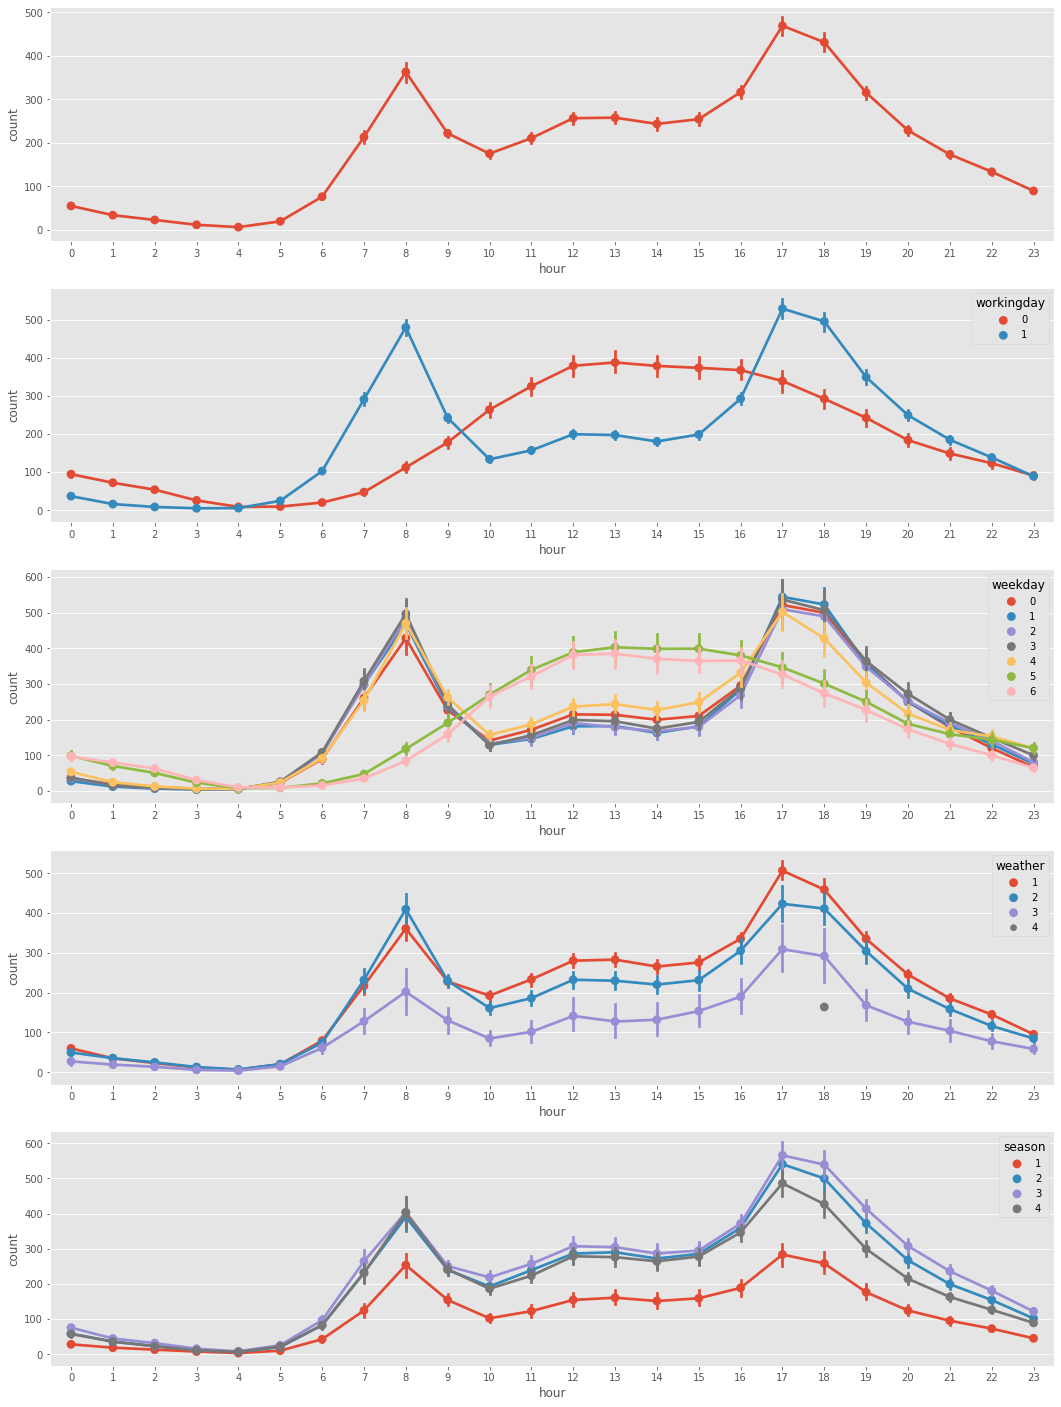

In [17]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=data, x="hour", y="count", ax=ax1)
sns.pointplot(data=data, x="hour", y="count", hue="workingday", ax=ax2)
sns.pointplot(data=data, x="hour", y="count", hue="weekday", ax=ax3)
sns.pointplot(data=data, x="hour", y="count", hue="weather", ax=ax4)
sns.pointplot(data=data, x="hour", y="count", hue="season", ax=ax5)

In [0]:
Matt = data[["temp","atemp","casual","registered","humidity","windspeed","count"]]
Matt = Matt.corr()
mask = np.array(Matt)
mask[np.tril_indices_from(mask)] = False

(6.9, -0.1)

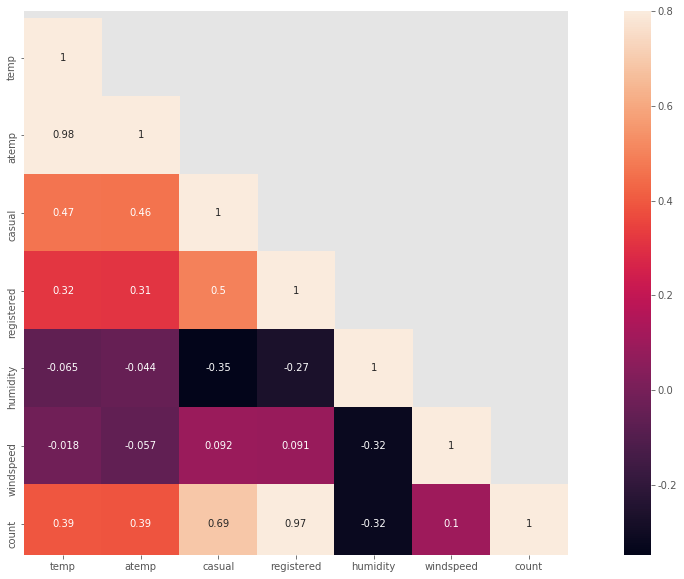

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(Matt, mask=mask,vmax=.8,square=True,annot=True)
## heatmap 짤림방지 코드
ax.set_ylim(len(Matt)-0.1, -0.1)

## 히트맵을 통해 알 수 있는 count와의 상관관계

- 온도, 습도, 풍속은 거의 연관관계가 없다.
- 대여량과 가장 연관 높은건 registered, 하지만 test 데이터에는 값이 없다.
- atemp와 temp는 0.98 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다.

## 산점도

- windspeed 의 데이터의 0 값이 너무 많은 feature Engineering을 통한 개선이 되는지 해봐야한다.

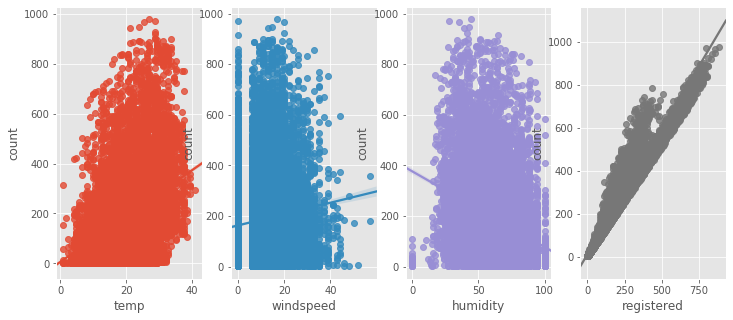

In [20]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
fig.set_size_inches(12,5)
sns.regplot(x="temp",y="count",data=data,ax=ax1)
sns.regplot(x="windspeed", y="count",data=data,ax=ax2)
sns.regplot(x="humidity", y="count",data=data, ax=ax3)
sns.regplot(x="registered", y="count",data=data,ax=ax4)

# train Without Outliers 



In [21]:
dataWithoutOutliers = data[np.abs(data["count"]-data["count"].mean())<=(3*data["count"].std())] 
print ("Shape Of The Before Ouliers: ",data.shape)
print ("Shape Of The After Ouliers: ",dataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 16)
Shape Of The After Ouliers:  (10739, 16)


# Count 값의 데이터 분포도 파악

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.        , 0.        , 0.        , ..., 6.59578051, 6.5971457 ,
         6.59850903])),
 (1.40968461015429, 4.523106928071492, 0.9537631807794262))

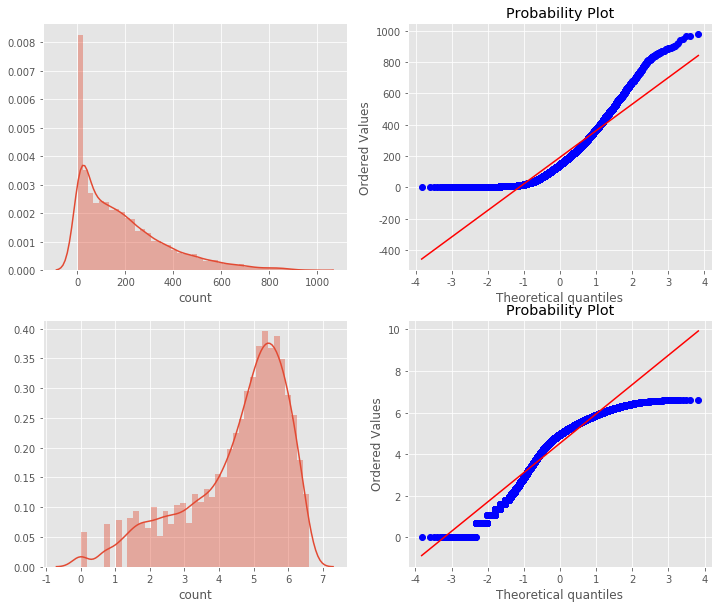

In [22]:
figure, axes = plt.subplots(ncols = 2, nrows= 2)
figure.set_size_inches(12,10)

sns.distplot(data["count"], ax=axes[0][0])
stats.probplot(data["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(dataWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log(dataWithoutOutliers["count"]),dist='norm', fit=True, plot=axes[1][1])

정규분포도를 띄는 데이터가 학습에 바람직하다. 하지만 지금까지의 과정을 통해 많이 나아짐을 볼 수 있다. 

# EDA 이후, 본격 학습에 참고할 내용
- 널 값은 없고 windspeed 에 대한 0의 값에 조정이 필요
- 여름 가을에 많이 탄다. 
- 테스트셋에는 count에 연관된 registered 변수가 없다.
- datetime을 통해 월, 시간을 꺼내야한다.

# scikitlearn 이용 과정

![사진 1](https://github.com/chldydgh4687/MY_AI/blob/master/ML/picture/sckit.png?raw=true)

# 평가지표 RMSLE
- 과대평가 항목보다 과소평가 된 항목에 패널티를 준다.
- 오차가 작을수록 정확도가 높다.

In [0]:
def rmsle(predicted_values, actual_values):

  predicted_values = np.array(predicted_values)
  actual_values = np.array(actual_values)

  log_predict = np.log(predicted_values + 1)
  log_actual = np.log(actual_values + 1)

  difference = log_predict - log_actual

  difference = np.square(difference)

  mean_difference = difference.mean()
  score = np.sqrt(mean_difference)
  return score

# KFold 교차검증
- ![대체 텍스트](https://raw.githubusercontent.com/chldydgh4687/MY_AI/master/ML/picture/kfold.png)

# EDA 이후, 본격 학습에 참고할 내용
- 널 값은 없고 windspeed 에 대한 0의 값에 조정이 필요
- 여름 가을에 많이 탄다. 
- 테스트셋에는 count에 연관된 registered 변수가 없다.
- datetime을 통해 월, 시간을 꺼내야한다.

In [24]:
train = pd.read_csv("/content/input/train.csv",parse_dates=["datetime"])
train.shape

(10886, 12)

In [25]:
test = pd.read_csv("/content/input/test.csv",parse_dates=["datetime"])
test.shape

(6493, 9)

## Feature Engineering

In [26]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["weekday"] = train["datetime"].dt.weekday
train.shape

(10886, 16)

In [27]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["weekday"] = test["datetime"].dt.weekday
test.shape

(6493, 13)

In [28]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


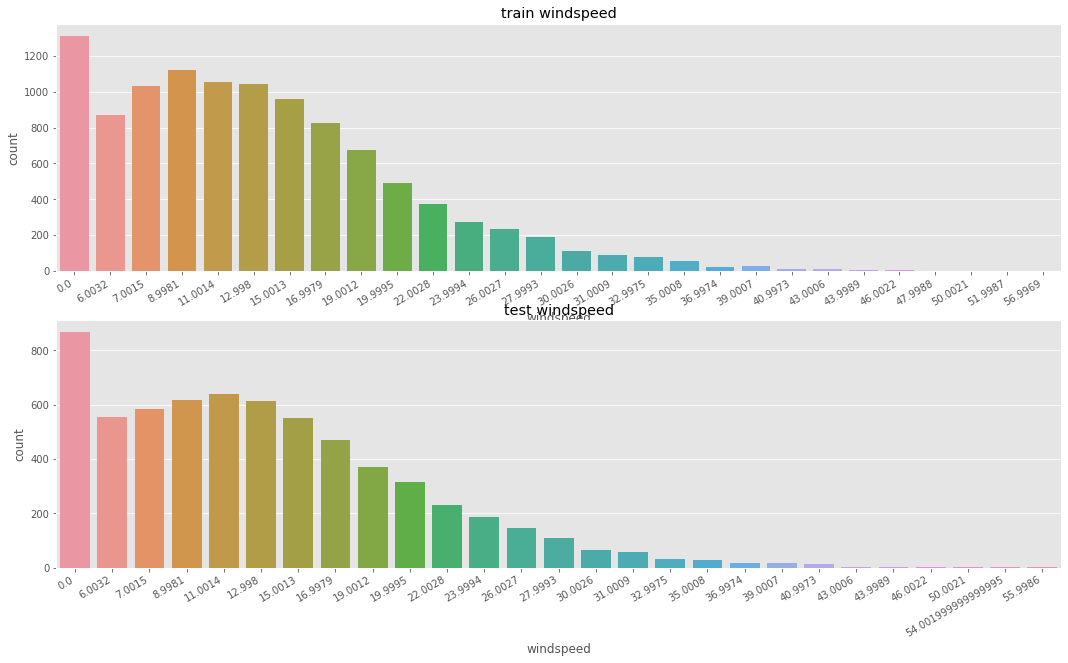

In [29]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed",ax=axes[0])


plt.sca(axes[1])
## x축 레이블이름 겹침 방지
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed",ax=axes[1])

In [30]:
trainWind0 = train.loc[train['windspeed']==0]
trainWindNot0 = train.loc[train['windspeed']!=0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 16)
(9573, 16)


In [0]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):

  dataWind0 = data.loc[data['windspeed']==0]
  dataWindnot0 = data.loc[data['windspeed']!=0]
  wcol = ["season","weather","humidity","month","temp","year","atemp"]

  dataWindnot0["windspeed"] = dataWindnot0["windspeed"].astype("str")

  rfModel_wind = RandomForestClassifier()
  rfModel_wind.fit(dataWindnot0[wcol], dataWindnot0["windspeed"])

  wind0Values = rfModel_wind.predict( X = dataWind0[wcol])

  predictWind0 = dataWind0
  predictWindNot0 = dataWindnot0

  predictWind0["windspeed"] = wind0Values
  data = predictWindNot0.append(predictWind0)

  data["windspeed"] = data["windspeed"].astype("float")

  data.reset_index(inplace = True)
  data.drop('index', inplace=True, axis=1)
  return data

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


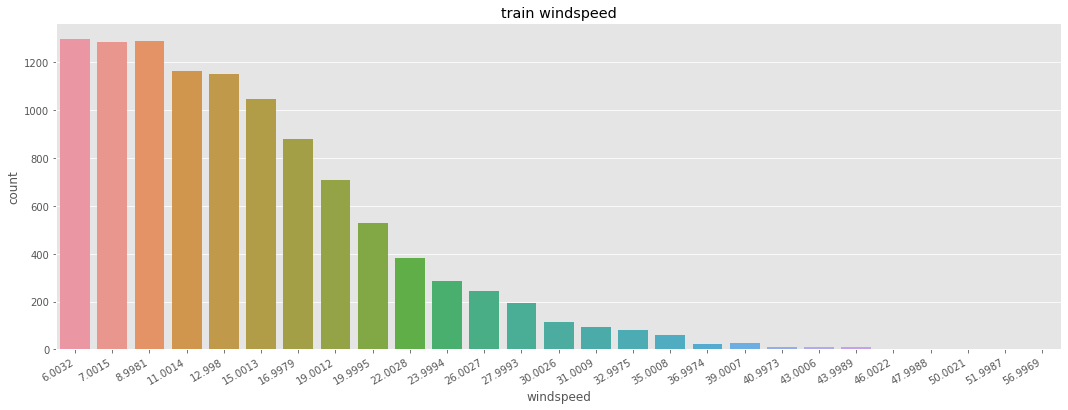

In [32]:
train = predict_windspeed(train)

fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha = 'right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed",ax=ax1)


## Feature Selection

- 신호와 잡음을 구분이 목적
- 피쳐가 많다고 해서 좋은 성능을 내지 않는다.
- 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피쳐는 제거한다.

In [0]:
def change_category(data):

  categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
  for var in categoryVariableList:
    data[var] = data[var].astype("category")

In [0]:
change_category(train)
change_category(test)

In [35]:
feautre_names = ["hour","weekday","month","season","weather","holiday","workingday","temp","atemp","humidity","windspeed"]

feautre_names

['hour',
 'weekday',
 'month',
 'season',
 'weather',
 'holiday',
 'workingday',
 'temp',
 'atemp',
 'humidity',
 'windspeed']

In [36]:
X_train = train[feautre_names]
print(X_train.shape)
X_train.head()

(10886, 11)


,hour,weekday,month,season,weather,holiday,workingday,temp,atemp,humidity,windspeed
0,5,5,1,1,2,0,0,9.84,12.880,75,6.0032
1,10,5,1,1,1,0,0,15.58,19.695,76,16.9979
2,11,5,1,1,1,0,0,14.76,16.665,81,19.0012
3,12,5,1,1,1,0,0,17.22,21.210,77,19.0012
4,13,5,1,1,2,0,0,18.86,22.725,72,19.9995


In [37]:
X_test = test[feautre_names]
print(X_test.shape)
X_test.head()

(6493, 11)


,hour,weekday,month,season,weather,holiday,workingday,temp,atemp,humidity,windspeed
0,0,3,1,1,1,0,1,10.66,11.365,56,26.0027
1,1,3,1,1,1,0,1,10.66,13.635,56,0.0000
2,2,3,1,1,1,0,1,10.66,13.635,56,0.0000
3,3,3,1,1,1,0,1,10.66,12.880,56,11.0014
4,4,3,1,1,1,0,1,10.66,12.880,56,11.0014


In [38]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# outlier 제거

In [39]:
trainWithoutOutliers = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())] 
print ("Shape Of The Before Ouliers: ",train.shape)
print ("Shape Of The After Ouliers: ",trainWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 16)
Shape Of The After Ouliers:  (10739, 16)


In [40]:
Xo_train = trainWithoutOutliers[feautre_names]
print(Xo_train.shape)
Xo_train.head()

(10739, 11)


,hour,weekday,month,season,weather,holiday,workingday,temp,atemp,humidity,windspeed
0,5,5,1,1,2,0,0,9.84,12.880,75,6.0032
1,10,5,1,1,1,0,0,15.58,19.695,76,16.9979
2,11,5,1,1,1,0,0,14.76,16.665,81,19.0012
3,12,5,1,1,1,0,0,17.22,21.210,77,19.0012
4,13,5,1,1,2,0,0,18.86,22.725,72,19.9995


In [41]:
Xo_test = test[feautre_names]
print(Xo_test.shape)
Xo_test.head()

(6493, 11)


,hour,weekday,month,season,weather,holiday,workingday,temp,atemp,humidity,windspeed
0,0,3,1,1,1,0,1,10.66,11.365,56,26.0027
1,1,3,1,1,1,0,1,10.66,13.635,56,0.0000
2,2,3,1,1,1,0,1,10.66,13.635,56,0.0000
3,3,3,1,1,1,0,1,10.66,12.880,56,11.0014
4,4,3,1,1,1,0,1,10.66,12.880,56,11.0014


In [42]:
label_name = "count"

yo_train = trainWithoutOutliers[label_name]

print(yo_train.shape)
yo_train.head()

(10739,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# Train

# RMSLE

In [43]:
from sklearn.metrics import make_scorer

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

# KFOLD

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

# RandomFroestRegressor

In [45]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list=[]

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

## oulier포함

In [46]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score = {0:.5f}".format(score))

CPU times: user 3.98 s, sys: 1.16 s, total: 5.14 s
Wall time: 45.9 s
Score = 0.40074


## oulier 제거

In [47]:
%time o_score = cross_val_score(model, Xo_train, yo_train, cv=k_fold, scoring=rmsle_scorer)
o_score = o_score.mean()
# 0에 근접할수록 좋은 데이터
print("o_Score = {0:.5f}".format(o_score))

CPU times: user 3.95 s, sys: 997 ms, total: 4.95 s
Wall time: 44.8 s
o_Score = 0.39969


## oulier 포함(예측)

In [48]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

## oulier 제거(예측)

In [49]:
model.fit(Xo_train,yo_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

# TEST

In [50]:
#예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 14.33,   5.81,   4.99,   3.97,   3.23,  17.72,  67.12, 163.84,
       332.73, 184.96])

[Text(0.5, 1.0, 'test')]

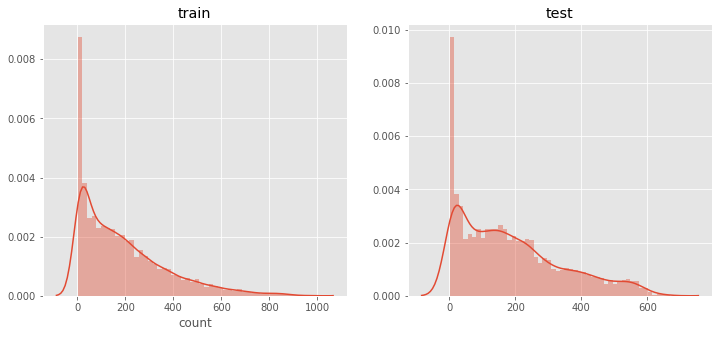

In [51]:
fig, (ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title = "train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

# oulier 제거(TEST)

In [52]:
#예측
o_predictions = model.predict(Xo_test)

print(o_predictions.shape)
o_predictions[0:10]

(6493,)


array([ 14.33,   5.81,   4.99,   3.97,   3.23,  17.72,  67.12, 163.84,
       332.73, 184.96])

[Text(0.5, 1.0, 'test')]

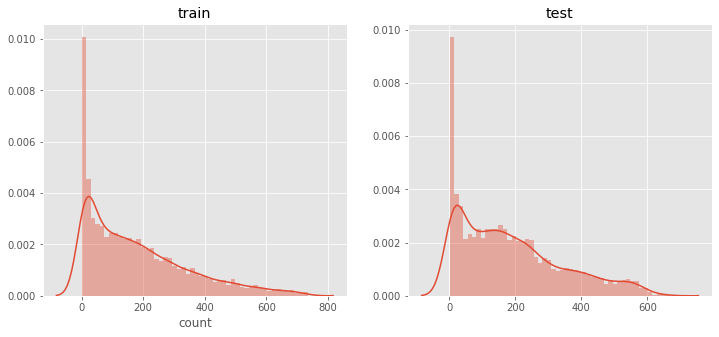

In [53]:
fig, (ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(yo_train,ax=ax1,bins=50)
ax1.set(title = "train")
sns.distplot(o_predictions,ax=ax2,bins=50)
ax2.set(title="test")

# Submit

In [54]:
submission = pd.read_csv("/content/input/sampleSubmission.csv")
o_submission = pd.read_csv("/content/input/sampleSubmission.csv")
submission

submission["count"] = predictions
o_submission["count"] = o_predictions

print(submission.shape)
submission.head()


(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,14.33
1,2011-01-20 01:00:00,5.81
2,2011-01-20 02:00:00,4.99
3,2011-01-20 03:00:00,3.97
4,2011-01-20 04:00:00,3.23


In [55]:

print(o_submission.shape)
o_submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,14.33
1,2011-01-20 01:00:00,5.81
2,2011-01-20 02:00:00,4.99
3,2011-01-20 03:00:00,3.97
4,2011-01-20 04:00:00,3.23


In [0]:
submission.to_csv("input/Score_{0:.5f}_sumission.csv".format(score),index=False)
o_submission.to_csv("input/o_Score_{0:.5f}_sumission.csv".format(o_score),index=False)